<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Milestone Project: SkimLit

Este projeto tem como objetivo reproduzir o artigo **PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts**. https://arxiv.org/abs/1710.06071

O resumo de artigos científicos de Medicina costumam ser blocos de texto de difícil interpretação imediata. Este artigo teve como propósito criar um modelo para classificação sequencial de sentenças, onde, uma vez apresentado um resumo, dividirá o texto em cinco categorias: Background, Conclusions, Methods, Objective e Results (Contexto, Conclusões, Métodos, Objetivo e Resultados), facilitando sua interpretação.

PubMed 200k RCT utiliza a arquitetura do modelo do artigo **Neural Networks for Joint Sentence Classification in Medical Paper Abstracts**. https://arxiv.org/abs/1612.05251

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random, re

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input
from tensorflow.keras.layers import Conv1D

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Setup

In [2]:
pd.set_option('display.max_colwidth', None)

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

# plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid')

### Constantes

In [52]:
SEMENTE = 2008193

COR = '#007f66'

DIRETORIO_20K = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'
DIRETORIO_200K = '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign'

# PubMed 200k RCT - Table 2
LIMITE_DICIONARIO_20K = 68000
LIMITE_DICIONARIO_200K = 331000

# Neural Networks for Joint Sentence Classification - Figure 1
LIMITE_INCORPORADOR = 256  # O artigo utiliza 300, mas é recomendado um múltiplo binário.

LOTE_TAMANHO = 32

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'softmax'

FILTROS = 64
NUCLEO_TAMANHO = 5
PREENCHIMENTO = 'same'

PERDA = 'categorical_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 3

### Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-30 20:39:57--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5909 (5.8K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   5.77K  --.-KB/s    in 0s      

2023-01-30 20:39:57 (69.6 MB/s) - ‘funcoes.py’ saved [5909/5909]



In [5]:
from funcoes import avaliar_modelo, grafico_historico_por_iteracao

In [6]:
def preprocessar_texto(arquivo):
    """
    Retorna uma lista de dicionários com o conteúdo das linhas do arquivo informado.

    Cada dicionário contém o código do resumo, o total de linhas, o número, a classe e o texto da linha.
    {codigo, total, numero, classe, texto}
    """

    with open(arquivo, 'r') as a: linhas_arquivo = a.readlines()
    linhas = ''  # Linhas do texto
    saida = []   # Lista de dicionários

    for linha in linhas_arquivo:
        if linha.startswith('###'):            # Verifica se a linha inicia com '###'.
            codigo = re.sub('\D+', '', linha)  # Extrai o código do resumo.
            linhas = ''                        # Limpa as linhas de texto.
        
        elif linha.isspace():                       # Verifica se a linha é vazia.
            linhas_separadas = linhas.splitlines()  # Separa linhas de texto.

            for linha_numero, linha_completa in enumerate(linhas_separadas):  # Itera sobre cada uma das linhas de texto.
                linha_dados = {}                                              # Dicionário com os dados da linha.
                linha_conteudo = linha_completa.split('\t')                   # Separa classe e texto.

                linha_dados['codigo'] = codigo                    # Código do resumo.
                linha_dados['total'] = len(linhas_separadas)      # Total de linhas.
                linha_dados['numero'] = linha_numero              # Número da linha.
                linha_dados['classe'] = linha_conteudo[0]         # Classe da linha.
                linha_dados['texto'] = linha_conteudo[1].lower()  # Texto da linha, em caixa baixa.

                saida.append(linha_dados)  # Acrescenta o dicionário à lista.

        else:
            linhas += linha  # Acrescenta a linha atual às linhas de texto.

    return saida

## Dados

In [7]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.92 MiB/s, done.


### Pré-processamento

In [8]:
linhas_treino    = preprocessar_texto(f'{DIRETORIO_20K}/train.txt')  # Dados de treino
linhas_validacao = preprocessar_texto(f'{DIRETORIO_20K}/dev.txt')    # Dados de validação
linhas_teste     = preprocessar_texto(f'{DIRETORIO_20K}/test.txt')   # Dados de teste

In [9]:
df_treino    = pd.DataFrame(linhas_treino)
df_validacao = pd.DataFrame(linhas_validacao)
df_teste     = pd.DataFrame(linhas_teste)

### Verificação

In [10]:
df_treino[:12]

,codigo,total,numero,classe,texto
0,24293578,12,0,OBJECTIVE,"to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) ."
1,24293578,12,1,METHODS,a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
2,24293578,12,2,METHODS,outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
3,24293578,12,3,METHODS,pain was assessed using the visual analog pain scale ( @-@ mm ) .
4,24293578,12,4,METHODS,"secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) ."
5,24293578,12,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured ."
6,24293578,12,6,RESULTS,"there was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , pga , and @mwd at @ weeks ."
7,24293578,12,7,RESULTS,"the mean difference between treatment arms ( @ % ci ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively ."
8,24293578,12,8,RESULTS,"further , there was a clinically relevant reduction in the serum levels of il-@ , il-@ , tnf - , and hscrp at @ weeks in the intervention group when compared to the placebo group ."
9,24293578,12,9,RESULTS,these differences remained significant at @ weeks .


In [11]:
df_treino['classe'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: classe, dtype: int64

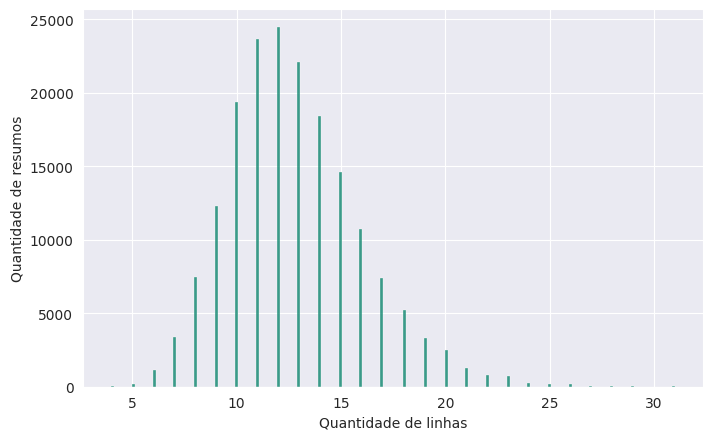

In [12]:
sns.histplot(data=df_treino, x='total', color=COR)

plt.xlabel('Quantidade de linhas')
plt.ylabel('Quantidade de resumos');

### Rótulos numéricos

#### One-hot

In [13]:
codificador_onehot = OneHotEncoder(sparse=False)

rotulos_onehot_treino    = codificador_onehot.fit_transform(df_treino['classe'].to_numpy().reshape(-1, 1))
rotulos_onehot_validacao = codificador_onehot.transform(df_validacao['classe'].to_numpy().reshape(-1, 1))
rotulos_onehot_teste     = codificador_onehot.transform(df_teste['classe'].to_numpy().reshape(-1, 1))

In [14]:
rotulos_onehot_treino

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### Inteiros

In [15]:
codificador_int = LabelEncoder()

rotulos_int_treino    = codificador_int.fit_transform(df_treino['classe'].to_numpy())
rotulos_int_validacao = codificador_int.transform(df_validacao['classe'].to_numpy())
rotulos_int_teste     = codificador_int.transform(df_teste['classe'].to_numpy())

In [16]:
rotulos_int_treino

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
classes = codificador_int.classes_
classes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

### Treino e teste

In [18]:
X_train = df_treino['texto']
y_train = rotulos_int_treino

X_test = df_validacao['texto']
y_test = rotulos_int_validacao

## Modelos

In [19]:
modelos = [None] * 5

### Modelo 0: TF-IDF Naive-Bayes

In [20]:
modelos[0] = {}

In [21]:
modelo_nome = 'modelo_0_tfidf_naive_bayes'

modelo = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', MultinomialNB())])

modelo.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
y_pred = modelo.predict(X_test)

In [23]:
previsoes = np.zeros((y_pred.size, y_pred.max() + 1))
previsoes[np.arange(y_pred.size), y_pred] = 1

              precision    recall  f1-score   support

  BACKGROUND       0.66      0.49      0.56      3449
 CONCLUSIONS       0.65      0.59      0.61      4582
     METHODS       0.72      0.87      0.79      9964
   OBJECTIVE       0.75      0.14      0.23      2376
     RESULTS       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



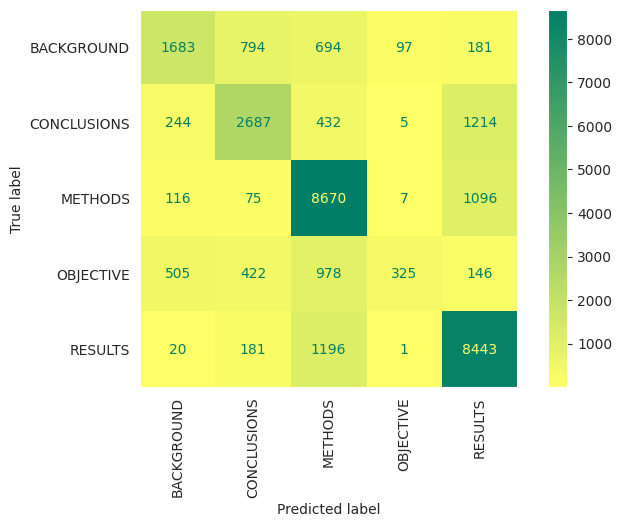

In [24]:
avaliacao = avaliar_modelo(y_test, y_pred, classes)

In [25]:
avaliacao

{'acuracia': 0.7218323844829869,
 'precisao': 0.7186466952323352,
 'revocacao': 0.7218323844829869,
 'pontuacao-f1': 0.6989250353450294}

In [26]:
modelos[0]['nome']           = modelo_nome
modelos[0]['descricao']      = 'Modelo 0: TF-IDF Naive-Bayes'
modelos[0]['modelo']         = modelo
modelos[0]['historico']      = None
modelos[0]['probabilidades'] = y_pred
modelos[0]['previsoes']      = previsoes
modelos[0]['acuracia']       = avaliacao['acuracia']
modelos[0]['precisao']       = avaliacao['precisao']
modelos[0]['revocacao']      = avaliacao['revocacao']
modelos[0]['pontuacao-f1']   = avaliacao['pontuacao-f1']

### Preparação dos textos para modelos de sequência profunda.

In [27]:
palavras_por_texto    = [len(texto.split()) for texto in X_train]
palavras_por_texto_95 = int(np.percentile(palavras_por_texto, 95))  # Quantidade máxima de palavras para 95% dos textos.

In [28]:
print(f"Média: {np.mean(palavras_por_texto)}")
print(f"Máximo: {np.max(palavras_por_texto)}")
print(f"95%: {palavras_por_texto_95}")

Média: 26.338269273494777
Máximo: 296
95%: 55


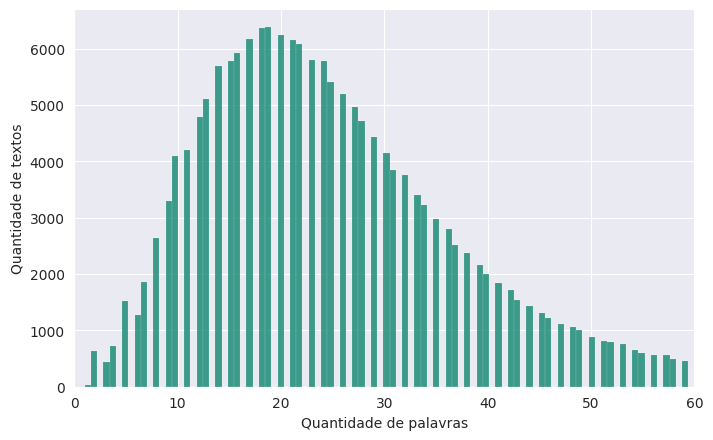

In [29]:
sns.histplot(x=palavras_por_texto, color=COR)

plt.xlim(0, 60)

plt.xlabel('Quantidade de palavras')
plt.ylabel('Quantidade de textos');

#### Vetorização

In [30]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO_20K,
                                output_mode='int',
                                output_sequence_length=palavras_por_texto_95)

vetorizador.adapt(X_train)

In [31]:
vetorizador.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### Vocabulário

In [32]:
vocabulario = vetorizador.get_vocabulary()

print(f"Tamanho do vocabulário: {len(vocabulario)}")
print(f"10 palavras mais comuns: {vocabulario[:10]}")
print(f"10 palavras menos comuns: {vocabulario[-10:]}")

Tamanho do vocabulário: 64841
10 palavras mais comuns: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
10 palavras menos comuns: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


#### Incorporação

In [33]:
incorporador = Embedding(input_dim=len(vocabulario),
                         output_dim=LIMITE_INCORPORADOR,
                         mask_zero=True,
                         input_length=palavras_por_texto_95)

`mask_zero=True` otimiza o tratamento de preenchimento com valor zero nas camadas subsequentes e na função de perda.

Mais informações: https://stackoverflow.com/questions/47485216/how-does-mask-zero-in-keras-embedding-layer-work

In [34]:
incorporador.get_config()

{'name': 'embedding',
 'trainable': True,
 'batch_input_shape': (None, 55),
 'dtype': 'float32',
 'input_dim': 64841,
 'output_dim': 256,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': True,
 'input_length': 55}

#### Verificação

In [35]:
texto_aleatorio = random.choice(X_train)

vetorizado = vetorizador([texto_aleatorio])
incorporado = incorporador(vetorizado)

print(texto_aleatorio)
print()
print(f"Quantidade de palavras: {len(texto_aleatorio.split())}")
print(f"Formato vetorizado: {vetorizado.shape}")
print(f"Formato incorporado: {incorporado.shape}")
print()
print(vetorizado)
print()
print(incorporado)

median cycles of @-fluorouracil were reduced in the linifanib arms , versus the bevacizumab arm .

Quantidade de palavras: 16
Formato vetorizado: (1, 55)
Formato incorporado: (1, 55, 256)

tf.Tensor(
[[ 193 1039    4 2898    9  191    5    2 8413  490  110    2 1034  207
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)

tf.Tensor(
[[[-0.00656953  0.04971298  0.04499714 ...  0.02672731  0.00302564
   -0.00046121]
  [ 0.04766697 -0.03455477  0.04963299 ...  0.02994002  0.04775376
    0.03519921]
  [ 0.00688462 -0.03971469 -0.04755082 ...  0.03442143 -0.03588052
   -0.01843715]
  ...
  [-0.00936107  0.00774754 -0.0176188  ...  0.00904591 -0.03322052
   -0.02352551]
  [-0.00936107  0.00774754 -0.0176188  ...  0.00904591 -0.03322052
   -0.02352551]
  [-0.00936107  0.00774754 -0.0176188  ...  0.0090459

#### Criação de datasets

Fusão dos dados e rótulos em datasets para ganho de performance.

Better performance with the tf.data API: https://www.tensorflow.org/guide/data_performance

In [36]:
# Datasets
dados_treino    = Dataset.from_tensor_slices((df_treino['texto'], rotulos_onehot_treino))
dados_validacao = Dataset.from_tensor_slices((df_validacao['texto'], rotulos_onehot_validacao))
dados_teste     = Dataset.from_tensor_slices((df_teste['texto'], rotulos_onehot_teste))

In [37]:
dados_treino

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Pré-buscas
dados_treino    = dados_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dados_validacao = dados_validacao.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dados_teste     = dados_teste.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

In [39]:
dados_treino

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Modelo 1: Conv1D com incorporação de palavras

In [53]:
modelos[1] = {}

In [54]:
modelo_nome = 'modelo_1_conv1d_inc_palavras'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

camadas = Conv1D(filters=FILTROS,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas)

camadas = GlobalAveragePooling1D(name='agrupamento_media_global')(camadas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelo = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

historico = modelo.fit(dados_treino,
                       epochs=ITERACOES,
                       validation_data=dados_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 73s 13ms/step - loss: 0.2636 - accuracy: 0.9151 - val_loss: 0.7805 - val_accuracy: 0.7848
Epoch 2/3
5627/5627 [==============================] - 72s 13ms/step - loss: 0.1701 - accuracy: 0.9472 - val_loss: 0.9148 - val_accuracy: 0.7785
Epoch 3/3
5627/5627 [==============================] - 71s 13ms/step - loss: 0.1336 - accuracy: 0.9604 - val_loss: 1.0600 - val_accuracy: 0.7713


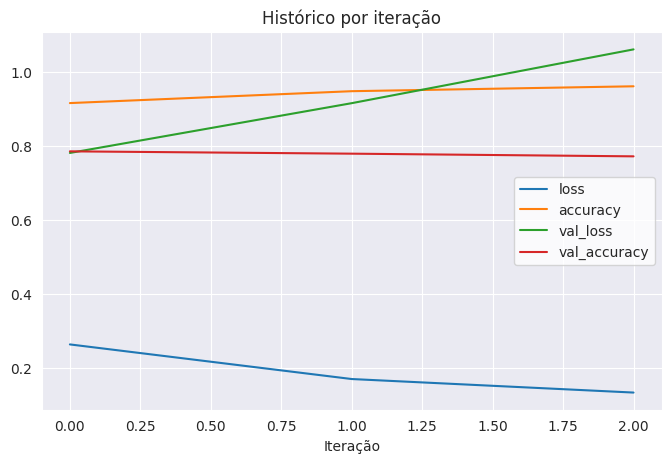

In [55]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.58      0.61      0.60      3449
 CONCLUSIONS       0.68      0.69      0.69      4582
     METHODS       0.87      0.85      0.86      9964
   OBJECTIVE       0.61      0.47      0.53      2376
     RESULTS       0.82      0.86      0.84      9841

    accuracy                           0.77     30212
   macro avg       0.71      0.70      0.70     30212
weighted avg       0.77      0.77      0.77     30212



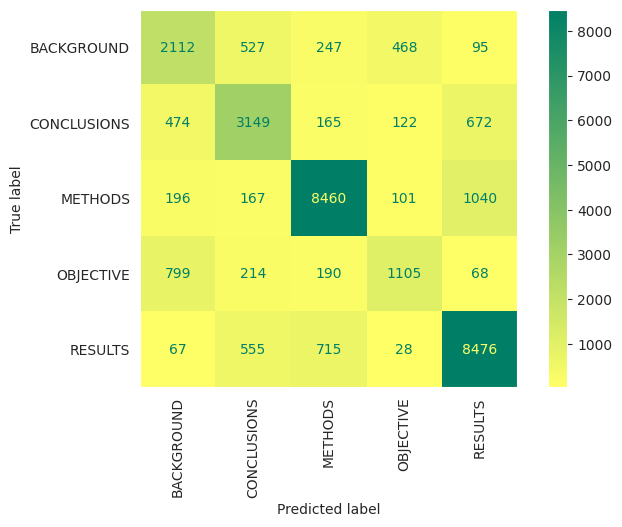

In [56]:
probabilidades = modelo.predict(dados_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacao      = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [57]:
avaliacao

{'acuracia': 0.7712829339335363,
 'precisao': 0.7693931747969623,
 'revocacao': 0.7712829339335363,
 'pontuacao-f1': 0.7693561786246591}

In [58]:
modelos[1]['nome']           = modelo_nome
modelos[1]['descricao']      = 'Modelo 1: Conv1D com incorporação de palavras'
modelos[1]['modelo']         = modelo
modelos[1]['historico']      = historico
modelos[1]['probabilidades'] = probabilidades
modelos[1]['previsoes']      = previsoes
modelos[1]['acuracia']       = avaliacao['acuracia']
modelos[1]['precisao']       = avaliacao['precisao']
modelos[1]['revocacao']      = avaliacao['revocacao']
modelos[1]['pontuacao-f1']   = avaliacao['pontuacao-f1']

### Modelo 2: TFHub USE

In [ ]:
modelos[2] = {}

In [ ]:
modelo_nome = 'modelo_2_use'

entradas = Input(shape=[], dtype=ENTRADA_TIPO, name='camada_entrada')  # shape=[] para entradas de tamanho variável

camadas = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                         trainable=False,
                         name='camada_use')(entradas)

camadas = Dense(LIMITE_INCORPORADOR, activation=ATIVACAO_CNN, name='camada_relu')(camadas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelo = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

historico = modelo.fit(dados_treino,
                       epochs=ITERACOES,
                       validation_data=dados_validacao,
                       verbose=1)

In [ ]:
grafico_historico_por_iteracao(historico)

In [ ]:
probabilidades = modelo.predict(dados_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacao      = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [ ]:
avaliacao

In [ ]:
modelos[2]['nome']           = modelo_nome
modelos[2]['descricao']      = 'Modelo 2: TFHub USE'
modelos[2]['modelo']         = modelo
modelos[2]['historico']      = historico
modelos[2]['probabilidades'] = probabilidades
modelos[2]['previsoes']      = previsoes
modelos[2]['acuracia']       = avaliacao['acuracia']
modelos[2]['precisao']       = avaliacao['precisao']
modelos[2]['revocacao']      = avaliacao['revocacao']
modelos[2]['pontuacao-f1']   = avaliacao['pontuacao-f1']